<a href="https://colab.research.google.com/github/shilpathota/AI_ML/blob/master/LLMCompression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# @title Install dependencies
!pip install -q "transformers[onnx]" datasets accelerate evaluate psutil onnx onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires flatbuffers>=24.3.25, but you have flatbuffers 2.0.7 which is incompatible.


# Imports Needed

In [2]:
# @title Imports and basic setup
import os
import time
import math
from pathlib import Path
import tempfile

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from datasets import load_dataset
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    pipeline,
)

import matplotlib.pyplot as plt
import pandas as pd
import psutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


# Load CLINC150 dataset and accuracy metric

In [3]:
# @title Load CLINC150 dataset
clinc = load_dataset("clinc_oos", "plus")
print(clinc)

# Intent label mapping
intents = clinc["test"].features["intent"]
print("Num intents:", intents.num_classes)

# Example
print(clinc["test"][42])

# Accuracy metric
accuracy_metric = evaluate.load("accuracy")


README.md: 0.00B [00:00, ?B/s]

plus/train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

plus/validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

plus/test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})
Num intents: 151
{'text': 'transfer $100 from my checking to saving account', 'intent': 133}


# PerformanceBenchmark helper (accuracy, size, latency)

In [6]:
# @title PerformanceBenchmark helper

class PerformanceBenchmark:
    def __init__(self, pipeline_obj, dataset, optim_type="BERT baseline",n_samples=200):
        self.pipeline = pipeline_obj
        self.dataset = dataset
        self.optim_type = optim_type
        self.n_samples = min(n_samples, len(dataset))  # use only a subset for speed

    def compute_accuracy(self):
        preds = []
        labels = []
        subset = (self.dataset.select(range(self.n_samples))
          if hasattr(self.dataset, "select")
          else self.dataset[: self.n_samples])
        for example in subset:
            pred_label = self.pipeline(example["text"])[0]["label"]
            label_id = example["intent"]
            preds.append(intents.str2int(pred_label))
            labels.append(label_id)
        acc = accuracy_metric.compute(predictions=preds, references=labels)
        print(f"[{self.optim_type}] Accuracy: {acc['accuracy']:.3f}")
        return {"accuracy": acc["accuracy"]}

    def compute_size(self):
        # Save model state_dict to a temporary file to estimate serialized size
        with tempfile.NamedTemporaryFile(delete=False) as tmp:
            torch.save(self.pipeline.model.state_dict(), tmp.name)
            size_mb = os.path.getsize(tmp.name) / (1024 * 1024)
        os.remove(tmp.name)
        print(f"[{self.optim_type}] Model size: {size_mb:.2f} MB")
        return {"size_mb": size_mb}

    def time_pipeline(self, num_examples=None, warmup=10):
        # simple per-example latency benchmark
        if num_examples is None or num_examples > self.n_samples:
            num_examples = self.n_samples

        texts = self.dataset[:num_examples]["text"]

        # Warmup to avoid first-run overhead
        for t in texts[:warmup]:
            _ = self.pipeline(t)

        times = []
        for t in texts:
            start = time.time()
            _ = self.pipeline(t)
            end = time.time()
            times.append((end - start) * 1000.0)  # ms

        mean = float(np.mean(times))
        std = float(np.std(times))
        print(f"[{self.optim_type}] Latency: {mean:.2f} ± {std:.2f} ms")
        return {"time_avg_ms": mean, "time_std_ms": std}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics


# Baseline: BERT teacher model + benchmark

In [7]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"

teacher_pipe = pipeline(
    "text-classification",
    model=teacher_ckpt,
    device=0 if torch.cuda.is_available() else -1,
)

perf_metrics = {}

pb_teacher = PerformanceBenchmark(
    pipeline_obj=teacher_pipe,
    dataset=clinc["test"],
    optim_type="BERT baseline",
    n_samples=200,   # or 300/500 later if you want

)
perf_metrics.update(pb_teacher.run_benchmark())
perf_metrics


Device set to use cpu


[BERT baseline] Model size: 418.16 MB
[BERT baseline] Latency: 103.76 ± 21.14 ms
[BERT baseline] Accuracy: 0.950


{'BERT baseline': {'size_mb': 418.1608667373657,
  'time_avg_ms': 103.75675916671753,
  'time_std_ms': 21.140383713355146,
  'accuracy': 0.95}}

# Utility: plot metrics (size vs latency vs accuracy)

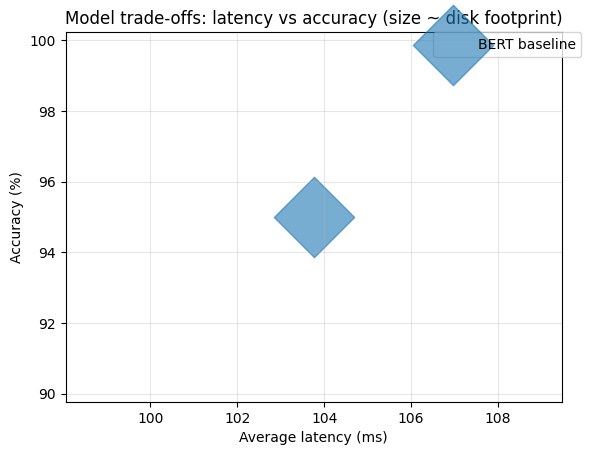

In [9]:

def plot_metrics(perf_metrics, current_optim_type=None):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")
    for name in df.index:
        row = df.loc[name]
        # Marker highlight for current model
        marker = "o"
        if current_optim_type is not None and name == current_optim_type:
            marker = "D"  # diamond
        plt.scatter(
            row["time_avg_ms"],
            row["accuracy"] * 100,
            s=row["size_mb"] * 4,   # scale bubble size a bit
            alpha=0.6,
            label=name,
            marker=marker,
        )
    legend = plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    # for handle in legend.legendHandles:
    #     handle.set_sizes([50])
    plt.xlabel("Average latency (ms)")
    plt.ylabel("Accuracy (%)")
    plt.title("Model trade-offs: latency vs accuracy (size ~ disk footprint)")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_metrics(perf_metrics, current_optim_type="BERT baseline")


# Knowledge Distillation (DistilBERT student from BERT teacher)

In [10]:
# @title DistillationTrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature


In [23]:
# @title DistillationTrainer (student + teacher)

class DistillationTrainer(Trainer):
    def __init__(self, teacher_model=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        if self.teacher_model is not None:
            self.teacher_model.eval()

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")

        # Student forward
        student_inputs = {k: v for k, v in inputs.items() if k != "labels"}
        outputs_student = model(**student_inputs)
        logits_student = outputs_student.logits

        # Standard CE loss
        loss_fct = nn.CrossEntropyLoss()
        loss_ce = loss_fct(logits_student, labels)

        # Distillation loss
        with torch.no_grad():
            outputs_teacher = self.teacher_model(**student_inputs)
            logits_teacher = outputs_teacher.logits

        T = self.args.temperature
        student_log_probs = nn.functional.log_softmax(logits_student / T, dim=-1)
        teacher_probs = nn.functional.softmax(logits_teacher / T, dim=-1)

        loss_kl = nn.functional.kl_div(
            student_log_probs, teacher_probs, reduction="batchmean"
        ) * (T ** 2)

        alpha = self.args.alpha
        loss = alpha * loss_ce + (1.0 - alpha) * loss_kl

        return (loss, outputs_student) if return_outputs else loss


In [24]:
# @title Prepare student DistilBERT and encoded dataset
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_batch(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(
    tokenize_batch,
    batched=True,
    remove_columns=["text"],
)
clinc_enc = clinc_enc.rename_column("intent", "labels")

def compute_metrics_for_trainer(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=preds, references=labels)


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [25]:
# @title Student config & init, teacher model
num_labels = intents.num_classes

# Use teacher's label mapping so all models share the same label IDs/strings
id2label = teacher_pipe.model.config.id2label
label2id = teacher_pipe.model.config.label2id

student_config = AutoConfig.from_pretrained(
    student_ckpt,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

def student_init():
    return AutoModelForSequenceClassification.from_pretrained(
        student_ckpt,
        config=student_config,
    )

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_ckpt,
    num_labels=num_labels,
).to(device)
teacher_model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [26]:
# @title Distillation training args
batch_size = 32
distilled_ckpt = "distilbert-base-uncased-finetuned-clinc"

student_training_args = DistillationTrainingArguments(
    output_dir=distilled_ckpt,
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    alpha=0.5,
    temperature=2.0,
    logging_steps=50,
    push_to_hub=False,
)



In [27]:
# @title Train DistilBERT student via distillation
train_subset = clinc_enc["train"].select(range(2000))
distil_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=train_subset,
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics_for_trainer,
    tokenizer=student_tokenizer,
)

distil_trainer.train()
distil_trainer.save_model(distilled_ckpt)  # make sure model is saved


/tmp/ipython-input-1792937943.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,2.877500


Device set to use cpu


[Distillation] Model size: 255.89 MB
[Distillation] Latency: 113.81 ± 108.24 ms
[Distillation] Accuracy: 0.700


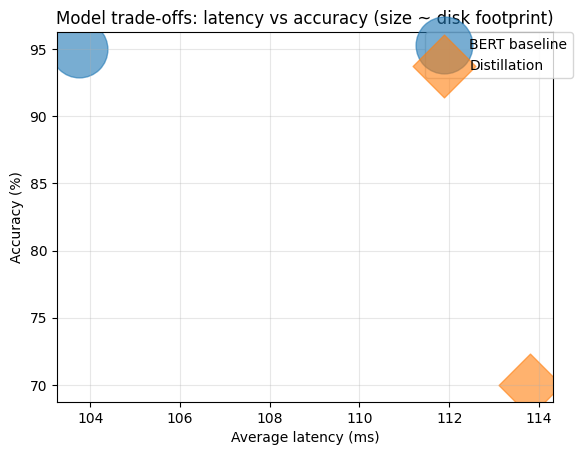

{'BERT baseline': {'size_mb': 418.1608667373657,
  'time_avg_ms': 103.75675916671753,
  'time_std_ms': 21.140383713355146,
  'accuracy': 0.95},
 'Distillation': {'size_mb': 255.8891363143921,
  'time_avg_ms': 113.80910873413086,
  'time_std_ms': 108.23727783960481,
  'accuracy': 0.7}}

In [28]:
# @title Benchmark distilled DistilBERT model
distilled_pipe = pipeline(
    "text-classification",
    model=distilled_ckpt,
    tokenizer=student_tokenizer,
    device=0 if torch.cuda.is_available() else -1,
)

pb_distilled = PerformanceBenchmark(
    pipeline_obj=distilled_pipe,
    dataset=clinc["test"],
    optim_type="Distillation",
)
perf_metrics.update(pb_distilled.run_benchmark())

plot_metrics(perf_metrics, current_optim_type="Distillation")
perf_metrics


# Quantization: FP32 → INT8 (dynamic) + benchmark

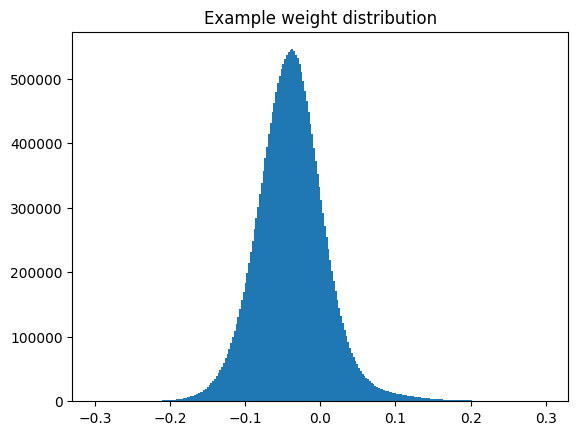

In [30]:
# @title Plot weight histogram for one layer (optional)
state_dict = distilled_pipe.model.state_dict()
some_weight = next(iter(state_dict.values()))
plt.hist(some_weight.flatten().cpu().numpy(), bins=250, range=(-0.3, 0.3))
plt.title("Example weight distribution")
plt.show()


In [31]:
# @title FP32 vs INT8-like matmul micro-benchmark
a = torch.randn(1024, 1024)
b = torch.randn(1024, 1024)

# FP32
start = time.time()
for _ in range(10):
    _ = a @ b
end = time.time()
print("FP32 matmul (10 runs):", (end - start) * 1000, "ms")

# INT8-like: naive simulate quantization by cast
a_int8 = (a * 127).clamp(-128, 127).to(torch.int8)
b_int8 = (b * 127).clamp(-128, 127).to(torch.int8)

start = time.time()
for _ in range(10):
    _ = (a_int8.to(torch.float32) @ b_int8.to(torch.float32))
end = time.time()
print("INT8-like matmul (10 runs):", (end - start) * 1000, "ms")


FP32 matmul (10 runs): 361.3593578338623 ms
INT8-like matmul (10 runs): 476.607084274292 ms


/tmp/ipython-input-441738465.py:7: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_dynamic(
Device set to use cpu


[Distillation + quantization] Model size: 132.40 MB
[Distillation + quantization] Latency: 20.81 ± 3.56 ms
[Distillation + quantization] Accuracy: 0.635


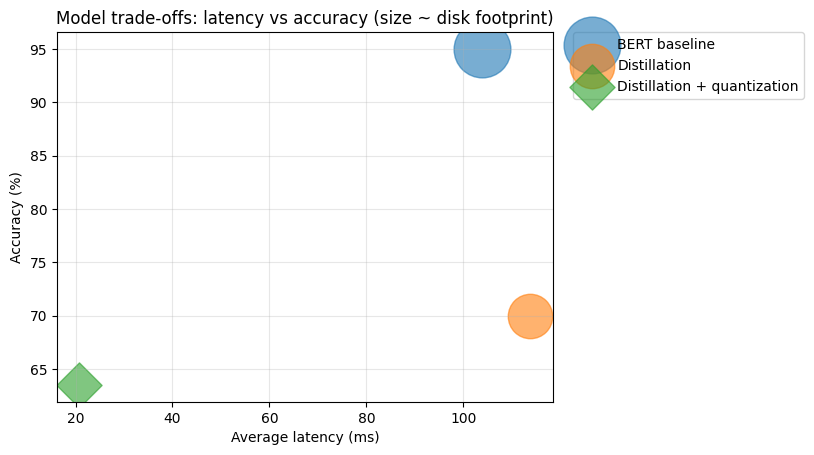

{'BERT baseline': {'size_mb': 418.1608667373657,
  'time_avg_ms': 103.75675916671753,
  'time_std_ms': 21.140383713355146,
  'accuracy': 0.95},
 'Distillation': {'size_mb': 255.8891363143921,
  'time_avg_ms': 113.80910873413086,
  'time_std_ms': 108.23727783960481,
  'accuracy': 0.7},
 'Distillation + quantization': {'size_mb': 132.39892482757568,
  'time_avg_ms': 20.80845355987549,
  'time_std_ms': 3.556288785936179,
  'accuracy': 0.635}}

In [32]:
# @title Dynamic quantization and benchmark
from torch.quantization import quantize_dynamic

# reload distilled model specifically on CPU
model_cpu = AutoModelForSequenceClassification.from_pretrained(distilled_ckpt).to("cpu")

model_quantized = quantize_dynamic(
    model_cpu,
    {nn.Linear},        # quantize only linear layers
    dtype=torch.qint8,  # INT8
)

quantized_pipe = pipeline(
    "text-classification",
    model=model_quantized,
    tokenizer=student_tokenizer,
    device=-1,  # CPU
)

pb_quantized = PerformanceBenchmark(
    pipeline_obj=quantized_pipe,
    dataset=clinc["test"],
    optim_type="Distillation + quantization",
)

perf_metrics.update(pb_quantized.run_benchmark())
plot_metrics(perf_metrics, current_optim_type="Distillation + quantization")
perf_metrics


# Export to ONNX + run with ONNX Runtime

In [33]:
# @title OpenMP settings for ONNX Runtime
os.environ["OMP_NUM_THREADS"] = str(psutil.cpu_count(logical=True))
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"


In [36]:
!pip install onnx onnxruntime onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 9.4 MB/s eta 0:00:00


In [37]:
# @title Convert distilled model to ONNX
from transformers.onnx import export, FeaturesManager

onnx_dir = Path("onnx")
onnx_dir.mkdir(exist_ok=True)
onnx_model_path = onnx_dir / "distilled_clinc.onnx"

# Load PyTorch model and tokenizer
hf_model = AutoModelForSequenceClassification.from_pretrained(distilled_ckpt)
tokenizer = student_tokenizer

# Get ONNX config for sequence classification
model_kind, model_onnx_config = FeaturesManager.check_supported_model_or_raise(
    hf_model, feature="sequence-classification"
)
onnx_config = model_onnx_config(hf_model.config)

# Export to ONNX
export(
    preprocessor=tokenizer,
    model=hf_model,
    config=onnx_config,
    opset=onnx_config.default_onnx_opset,
    output=onnx_model_path,
)

print("ONNX model saved at:", onnx_model_path)


/usr/local/lib/python3.12/dist-packages/transformers/onnx/convert.py:170: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  onnx_export(
W1129 22:49:45.480000 257 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `DistilBertForSequenceClassification([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `DistilBertForSequenceClassification([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/no_previous_version.h:26: adapt: Assertion `

[torch.onnx] Translate the graph into ONNX... ✅
Applied 32 of general pattern rewrite rules.
ONNX model saved at: onnx/distilled_clinc.onnx


In [38]:
# @title ONNX Runtime session helper
from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions

def create_onnx_session(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

onnx_session = create_onnx_session(onnx_model_path)
onnx_session


In [41]:
# @title ONNX inference and benchmark

def onnx_predict(texts):
    # Tokenize via HF tokenizer
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="np",
    )
    inputs_onnx = {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
    }
    outputs = onnx_session.run(None, inputs_onnx)
    logits = outputs[0]
    preds = np.argmax(logits, axis=-1)
    labels = [intents.int2str(int(i)) for i in preds]
    return labels

# Quick sanity check
test_example_text = clinc["test"][0]["text"]
print("Text:", test_example_text)
print("Label (ONNX):", onnx_predict([test_example_text])[0])

def benchmark_onnx(num_examples=200, warmup=20):
    subset = clinc["test"].select(range(min(num_examples, len(clinc["test"]))))
    texts = [ex["text"] for ex in subset]
    # Warmup
    _ = onnx_predict(texts[:warmup])

    times = []
    for t in texts:
        start = time.time()
        _ = onnx_predict([t])
        end = time.time()
        times.append((end - start) * 1000.0)

    mean = float(np.mean(times))
    std = float(np.std(times))
    print(f"[ONNX Runtime] Latency: {mean:.2f} ± {std:.2f} ms")
    return {"time_avg_ms": mean, "time_std_ms": std}

onnx_metrics = benchmark_onnx()


Text: how would you say fly in italian
Label (ONNX): translate
[ONNX Runtime] Latency: 87.47 ± 53.88 ms


[ONNX] Model size: 0.69 MB
[ONNX] Accuracy: 0.050


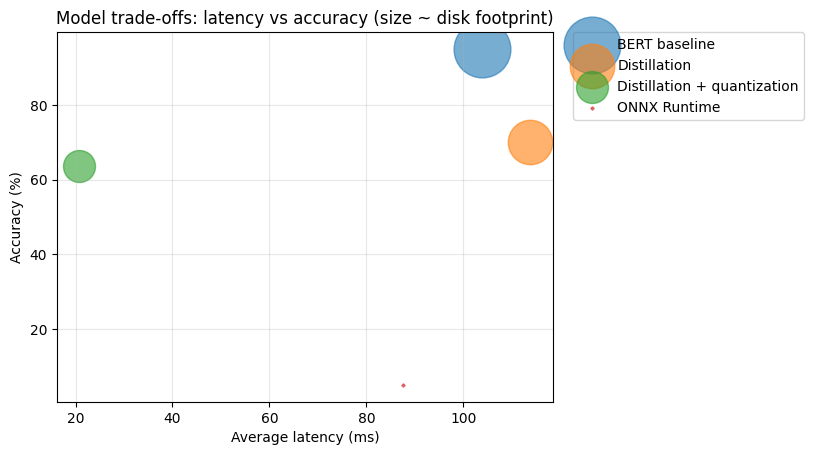

{'BERT baseline': {'size_mb': 418.1608667373657,
  'time_avg_ms': 103.75675916671753,
  'time_std_ms': 21.140383713355146,
  'accuracy': 0.95},
 'Distillation': {'size_mb': 255.8891363143921,
  'time_avg_ms': 113.80910873413086,
  'time_std_ms': 108.23727783960481,
  'accuracy': 0.7},
 'Distillation + quantization': {'size_mb': 132.39892482757568,
  'time_avg_ms': 20.80845355987549,
  'time_std_ms': 3.556288785936179,
  'accuracy': 0.635},
 'ONNX Runtime': {'size_mb': 0.6872072219848633,
  'time_avg_ms': 87.47055530548096,
  'time_std_ms': 53.87872255982167,
  'accuracy': 0.04981818181818182}}

In [44]:
# @title Add ONNX model to perf_metrics and plot
# Model size
onnx_size_mb = os.path.getsize(onnx_model_path) / (1024 * 1024)

# Accuracy using ONNX predictions
def onnx_accuracy():
    preds, labels = [], []
    for ex in clinc["test"]:
        pred_label = onnx_predict(ex["text"])[0]
        preds.append(intents.str2int(pred_label))
        labels.append(ex["intent"])
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    return acc["accuracy"]

onnx_acc = onnx_accuracy()
print(f"[ONNX] Model size: {onnx_size_mb:.2f} MB")
print(f"[ONNX] Accuracy: {onnx_acc:.3f}")

perf_metrics["ONNX Runtime"] = {
    "size_mb": onnx_size_mb,
    "time_avg_ms": onnx_metrics["time_avg_ms"],
    "time_std_ms": onnx_metrics["time_std_ms"],
    "accuracy": onnx_acc,
}

plot_metrics(perf_metrics, current_optim_type="ONNX Runtime")
perf_metrics
